# Large $\omega^2$ correction
In the limit of large $\omega^2$, large roundoff error can become problematic as the correlation almost exactly matches the uncorrelated contribution to solute diffusion, and so it becomes necessary to introduce an alternative treatment specific to the large $\omega^2$ limit. We will show the range of roundoff error by using FCC as an example.

In [1]:
import sys
sys.path.extend(['../'])
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from onsager import crystal, OnsagerCalc

Create FCC crystal, and diffuser with first neighbor range.

In [2]:
a0 = 1.
FCC = crystal.Crystal.FCC(a0, ["FCC"])
diffuser = OnsagerCalc.VacancyMediated(FCC, 0, FCC.sitelist(0), 
                                       FCC.jumpnetwork(0, 0.75*a0), 1)
print(diffuser)

Diffuser for atom 0 (FCC), Nthermo=1
#Lattice:
  a1 = [ 0.   0.5  0.5]
  a2 = [ 0.5  0.   0.5]
  a3 = [ 0.5  0.5  0. ]
#Basis:
  (FCC) 0.0 = [ 0.  0.  0.]
vacancy configurations:
v:+0.000,+0.000,+0.000
solute configurations:
s:+0.000,+0.000,+0.000
solute-vacancy configurations:
s:+0.000,+0.000,+0.000-v:-1.000,+0.000,+0.000
omega0 jumps:
omega0:v:+0.000,+0.000,+0.000^v:+1.000,+0.000,-1.000
omega1 jumps:
omega1:s:+0.000,+0.000,+0.000-v:+1.000,+0.000,-1.000^v:+2.000,+0.000,-2.000
omega1:s:+0.000,+0.000,+0.000-v:-1.000,+1.000,+0.000^v:+0.000,+1.000,-1.000
omega1:s:+0.000,+0.000,+0.000-v:+1.000,-1.000,+0.000^v:+2.000,-1.000,-1.000
omega1:s:+0.000,+0.000,+0.000-v:+0.000,-1.000,+0.000^v:+1.000,-1.000,-1.000
omega2 jumps:
omega2:s:+0.000,+0.000,+0.000-v:-1.000,+0.000,+1.000^s:+0.000,+0.000,+0.000-v:+1.000,+0.000,-1.000



Next, we fill out our thermodynamic dictionary.

In [3]:
tdict = {'preV': np.ones(1), 'eneV': np.zeros(1), 'preT0': np.ones(1), 'eneT0': np.zeros(1)}
tdict.update(diffuser.maketracerpreene(**tdict))
for k,v in tdict.items():
    print(k, v)

preV [ 1.]
preT1 [ 1.  1.  1.  1.]
eneT2 [ 0.]
eneSV [ 0.]
preSV [ 1.]
eneV [ 0.]
eneT1 [ 0.  0.  0.  0.]
eneS [ 0.]
preT2 [ 1.]
preT0 [ 1.]
preS [ 1.]
eneT0 [ 0.]


Now, to loop through a range of $\omega^2$ values from $10^{-17}$ to $10^{17}$, and evaluate the $L_{\mathrm{ss}}$ in three different ways:

1. Never using the large $\omega^2$ treatment (should fail for large $\omega^2$).
2. Always using the large $\omega^2$ treatment (should fail for small $\omega^2$).
3. Automatically switching treatment depending on $\omega^2$ value (should be accurate over entire range).

Because the failure can be pretty spectacular, we check for NaN, Inf, or 0 values.

In [4]:
print('omega2\tno large\tall large\tautomatic')
om2_list, correl_list = [], []
for om2pow in np.concatenate((np.linspace(-17,-13,num=17), np.linspace(13,17,num=17))):
    om2 = 10.**(om2pow)
    tdict['preT2'] = np.array([om2])
    correl = []
    for large_om2 in (1e33, 1e-33, 1e8):
        Lss, Lsv = diffuser.Lij(*diffuser.preene2betafree(1., **tdict), 
                                large_om2=large_om2)[1:3]
        if Lsv[0,0] is np.nan or Lsv[0,0] is np.inf or Lsv[0,0]==0 :
            c = 1
        else:
            c = -Lss[0,0]/Lsv[0,0]
        correl.append(c)
    om2_list.append(om2)
    correl_list.append(correl)
    print('10^{:+.2f}\t{:.8e}\t{:.8e}\t{:.16e}'.format(om2pow, 
                                                      correl[0], correl[1], correl[2]))

omega2	no large	all large	automatic
10^-17.00	7.81451419e-01	1.00000000e+00	7.8145141885543312e-01
10^-16.75	7.81451419e-01	1.00000000e+00	7.8145141885543312e-01
10^-16.50	7.81451419e-01	1.00000000e+00	7.8145141885543301e-01
10^-16.25	7.81451419e-01	1.00000000e+00	7.8145141885543301e-01
10^-16.00	7.81451419e-01	3.00239975e-01	7.8145141885543301e-01
10^-15.75	7.81451419e-01	5.33910566e-01	7.8145141885543312e-01
10^-15.50	7.81451419e-01	5.69665300e-01	7.8145141885543301e-01
10^-15.25	7.81451419e-01	8.44186728e-01	7.8145141885543312e-01
10^-15.00	7.81451419e-01	8.18836296e-01	7.8145141885543312e-01
10^-14.75	7.81451419e-01	7.62729380e-01	7.8145141885543312e-01
10^-14.50	7.81451419e-01	7.69817973e-01	7.8145141885543312e-01
10^-14.25	7.81451419e-01	7.79249287e-01	7.8145141885543301e-01
10^-14.00	7.81451419e-01	7.83234718e-01	7.8145141885543301e-01
10^-13.75	7.81451419e-01	7.81332535e-01	7.8145141885543312e-01
10^-13.50	7.81451419e-01	7.86830524e-01	7.8145141885543312e-01
10^-13.25	7.8145141

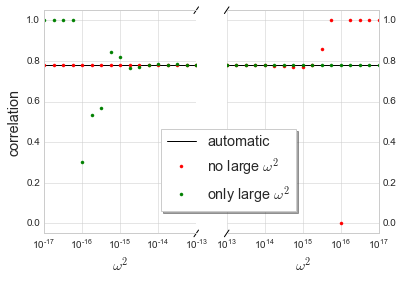

In [5]:
om2, correl = np.array(om2_list), np.array(correl_list)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for ax in (ax1, ax2):
    ax.plot(om2, correl[:,2], 'k', label='automatic')
    ax.plot(om2, correl[:,0], 'r.', label='no large $\omega^2$')
    ax.plot(om2, correl[:,1], 'g.', label='only large $\omega^2$')
ax1.set_xlim((1e-17,1e-13))
ax2.set_xlim((1e13,1e17))
ax1.set_ylim((-0.05,1.05))
ax2.set_ylim((-0.05,1.05))
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlabel('$\omega^2$', fontsize='x-large')
ax2.set_xlabel('$\omega^2$', fontsize='x-large')
ax1.set_ylabel('correlation', fontsize='x-large')
ax2.legend(bbox_to_anchor=(0,0.3,0.5,0.2), ncol=1, 
           shadow=True, frameon=True, fontsize='x-large')
ax1.yaxis.tick_left()
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
plt.show()
# plt.savefig('largeomega2.pdf', transparent=True, format='pdf')